# End-to-End Enterprise Data Science
**Template Name**: `PyCaret_Custom_Rich_Eval`
**Objectives**:
1.  **Churn Prediction** (Classification) - Metric: F1-Score, AUC.
2.  **CLV Forecasting** (Regression) - Metric: RMSE, MAE.
3.  **Customer Segmentation** (Clustering) - Metric: Silhouette.

This notebook includes acceptable "PyCaret-style" automation + **Deep Evaluation Plots** (Confusion Matrix, ROC, Residuals).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve,
                             mean_squared_error, mean_absolute_error, r2_score, silhouette_score)

# Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Boosters
try:
    from xgboost import XGBClassifier, XGBRegressor
except ImportError:
    XGBClassifier, XGBRegressor = None, None

# Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("Libraries Loaded.")


Libraries Loaded.


In [11]:
# Load Dataset
file_path = r"H:\coding\LLoyd_Banking_Group\DS\Customer_Churn_Data_Large.xlsx"
xls = pd.ExcelFile(file_path)

# 2. Daftar nama sheet sesuai screenshot kamu
# (Kita pakai list biar urutannya jelas mulai dari Demographics)
all_sheets = ['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']

# Variabel penampung untuk DataFrame gabungan
df_final = None

# 3. Loop Sakti untuk Read & Merge
for sheet_name in all_sheets:
    print(f"Sedang membaca sheet: {sheet_name}...")
    
    # Baca sheet saat ini
    df_current = pd.read_excel(xls, sheet_name=sheet_name)
    
    if df_final is None:
        # Jika ini sheet pertama (Demographics), jadikan pondasi awal
        df_final = df_current
    else:
        # Jika bukan sheet pertama, gabungkan ke df_final pakai 'inner join'
        # 'inner' berarti hanya mengambil CustomerID yang ada di KEDUA tabel (data lengkap)
        df_final = pd.merge(df_final, df_current, on='CustomerID', how='inner')

# 4. Tampilkan Hasil Akhir
print("\n--- PROSES MERGE SELESAI ---")
print(f"Jumlah Baris: {df_final.shape[0]}")
print(f"Jumlah Kolom: {df_final.shape[1]}")

display(df_final.head())
display(df_final.info())
display(df_final.describe())

# Define Global Features
NUMERIC_FEATURES = ['Age', 'AmountSpent']
CATEGORICAL_FEATURES = ['Gender', 'IncomeLevel', 'MaritalStatus', 'ProductCategory', 'ServiceUsage']

# Shared Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), NUMERIC_FEATURES),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), CATEGORICAL_FEATURES)
    ])


Sedang membaca sheet: Customer_Demographics...
Sedang membaca sheet: Transaction_History...
Sedang membaca sheet: Customer_Service...
Sedang membaca sheet: Online_Activity...
Sedang membaca sheet: Churn_Status...

--- PROSES MERGE SELESAI ---
Jumlah Baris: 5204
Jumlah Kolom: 17


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        5204 non-null   int64         
 1   Age               5204 non-null   int64         
 2   Gender            5204 non-null   object        
 3   MaritalStatus     5204 non-null   object        
 4   IncomeLevel       5204 non-null   object        
 5   TransactionID     5204 non-null   int64         
 6   TransactionDate   5204 non-null   datetime64[ns]
 7   AmountSpent       5204 non-null   float64       
 8   ProductCategory   5204 non-null   object        
 9   InteractionID     5204 non-null   int64         
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  LastLoginDate     5204 non-null   datetime64[ns]
 14  LoginFrequency    5204 n

None

,CustomerID,Age,TransactionID,TransactionDate,AmountSpent,InteractionID,InteractionDate,LastLoginDate,LoginFrequency,ChurnStatus
count,5204.000000,5204.000000,5204.000000,5204,5204.000000,5204.000000,5204,5204,5204.000000,5204.000000
mean,496.470407,43.140085,5495.988470,2022-06-29 08:30:15.219062272,254.354940,5921.861261,2022-07-01 16:31:10.561106944,2023-07-04 09:27:31.960030720,25.918332,0.205995
min,1.000000,18.000000,1000.000000,2022-01-01 00:00:00,5.180000,2015.000000,2022-01-01 00:00:00,2023-01-01 00:00:00,1.000000,0.000000
25%,244.000000,29.000000,3218.000000,2022-03-30 00:00:00,128.940000,3873.250000,2022-04-07 00:00:00,2023-04-04 00:00:00,14.000000,0.000000
50%,504.000000,43.000000,5490.000000,2022-06-27 00:00:00,255.175000,5903.000000,2022-07-02 00:00:00,2023-07-11 00:00:00,27.000000,0.000000
75%,743.000000,57.000000,7713.000000,2022-09-28 00:00:00,378.605000,7851.000000,2022-09-25 00:00:00,2023-10-01 00:00:00,38.000000,0.000000
max,995.000000,69.000000,9997.000000,2022-12-31 00:00:00,499.700000,9997.000000,2022-12-30 00:00:00,2023-12-31 00:00:00,49.000000,1.000000
std,286.681289,15.430343,2595.575295,NaN,143.329654,2332.331260,NaN,NaN,14.110627,0.404466


## 🛠️ Custom AutoML & Evaluation Functions
Includes `compare_models`, `tune_model`, and a new **`evaluate_model`** for rich plots.


In [12]:

import shutil

def save_pipeline_custom(pipeline, filename):
    # 1. Save locally (DS folder)
    joblib.dump(pipeline, filename)
    print(f"✅ Pipeline saved to {filename}")
    
    # 2. Auto-Deploy to Backend (MLE folder)
    # Go up one level (..), then into MLE/Backend
    backend_path = os.path.join('..', 'MLE', 'Backend', filename)
    
    try:
        shutil.copy(filename, backend_path)
        print(f"🚀 Auto-Deployed to API: {backend_path}")
    except Exception as e:
        print(f"⚠️ Could not auto-deploy: {e} (Check folder structure)")


## 1. Classification Phase (Churn Prediction)



>>> Comparing Models for CLASSIFICATION...
Best Model: XGBoost


,Model,Accuracy,AUC,F1,Prec.,Recall
0,XGBoost,0.938521,0.975952,0.849765,0.853774,0.845794
1,Random Forest,0.927954,0.974799,0.813896,0.867725,0.766355
2,Gradient Boosting,0.800192,0.769223,0.490196,0.515464,0.467290
3,Logistic Regression,0.566763,0.597328,0.349206,0.252610,0.565421


Best: XGBoost

>>> Evaluating Model (classification)...
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       827
           1       0.85      0.85      0.85       214

    accuracy                           0.94      1041
   macro avg       0.91      0.90      0.91      1041
weighted avg       0.94      0.94      0.94      1041



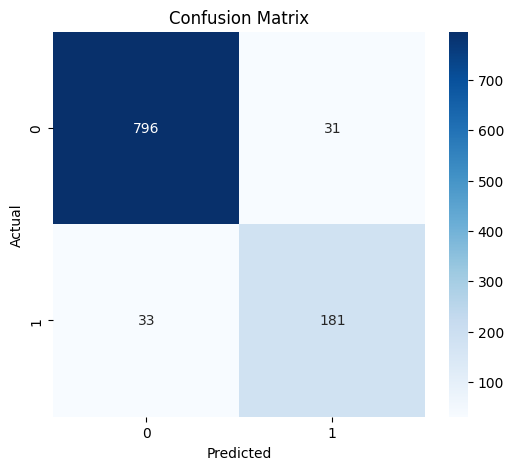

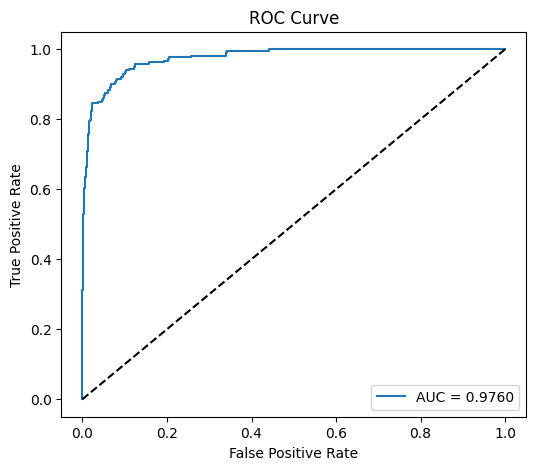

✅ Pipeline saved to lloyds_churn_model.pkl


In [13]:
# 1. Setup Data
df = df_final.copy()
X_clf = df.drop(columns = ['CustomerID', 'ChurnStatus','InteractionType'], axis=1)
y_clf = df['ChurnStatus']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42)

# 2. Compare Models
clf_results = compare_models_custom(X_clf, y_clf, task='classification')
display(clf_results.drop('Pipeline', axis=1).style.background_gradient(cmap='Greens'))

# 3. Select Best & Tune
best_clf_row = clf_results.iloc[0]
best_clf_pipe = best_clf_row['Pipeline']
print(f"Best: {best_clf_row['Model']}")

# Tuning (Simplified for demo)
if 'Forest' in best_clf_row['Model']:
    params = {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None]}
    best_clf_pipe = tune_model_custom(best_clf_pipe, params, X_clf, y_clf, task='classification')

# 4. Evaluate (Rich Plots)
evaluate_model_custom(best_clf_pipe, X_test_c, y_test_c, task='classification')

# 5. Save
save_pipeline_custom(best_clf_pipe, 'lloyds_churn_model.pkl')


In [14]:

# 5. Model Signature Inspection (Debugging)
def get_model_signature(pipeline):
    """
    Prints the expected input features for the model pipeline.
    Useful for debugging API schema mismatches.
    """
    try:
        if 'preprocessor' in pipeline.named_steps:
            preprocessor = pipeline.named_steps['preprocessor']
            
            # Extract transformers
            transformers = preprocessor.transformers_
            
            print("\n" + "="*40)
            print("🔍 MODEL INPUT SIGNATURE (Required Inputs)")
            print("="*40)
            
            for name, transformer, columns in transformers:
                if name != 'remainder': # Skip remainder
                    print(f"\n👉 Type: {name.upper()} ({len(columns)} features)")
                    print(f"   {list(columns)}")
                    
            print("\n" + "="*40 + "\n")
        else:
            print("Pipeline does not have a 'preprocessor' step.")
            
    except Exception as e:
        print(f"Could not extract signature: {e}")

# Run the inspection on the best model
get_model_signature(best_clf_pipe)



🔍 MODEL INPUT SIGNATURE (Required Inputs)

👉 Type: NUM (2 features)
   ['Age', 'AmountSpent']

👉 Type: CAT (5 features)
   ['Gender', 'IncomeLevel', 'MaritalStatus', 'ProductCategory', 'ServiceUsage']




DEBUG: Raw Feature Names Example: ['num__Age' 'num__AmountSpent' 'cat__Gender_F' 'cat__Gender_M'
 'cat__IncomeLevel_High']


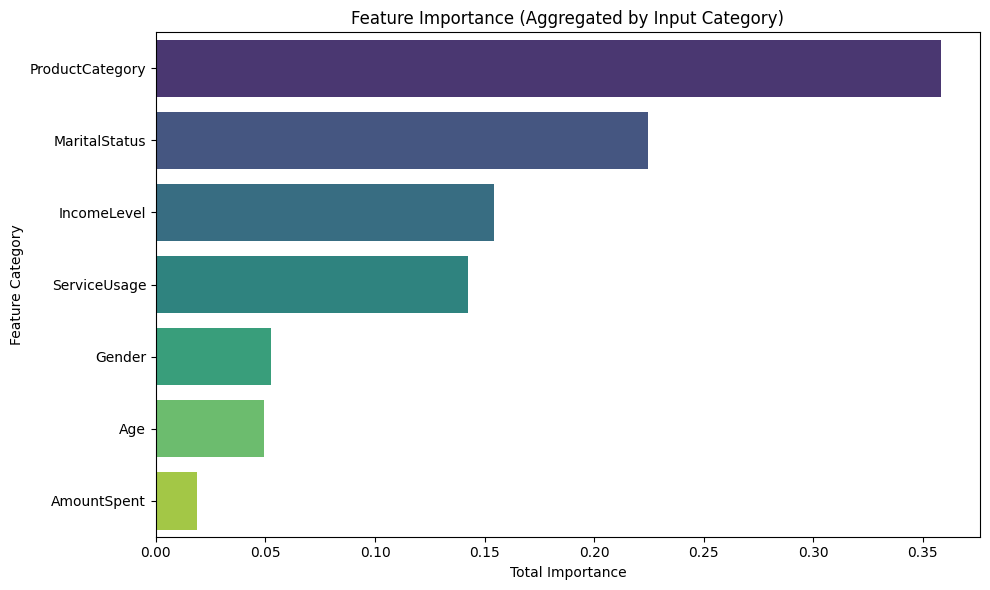

In [15]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_importance(pipeline, top_n=10):
    try:
        model = pipeline.named_steps['model']
        preprocessor = pipeline.named_steps['preprocessor']
        
        # 1. Get all encoded feature names
        try:
            # Try newer sklearn API
            feature_names = preprocessor.get_feature_names_out()
        except:
            # Fallback for older/custom pipelines (simulating extraction)
            num_feats = preprocessor.transformers_[0][2]
            cat_trans = preprocessor.transformers_[1][1]
            if hasattr(cat_trans, 'named_steps') and 'onehot' in cat_trans.named_steps:
                 ohe = cat_trans.named_steps['onehot']
                 cat_feats_encoded = ohe.get_feature_names_out(preprocessor.transformers_[1][2])
            else:
                 cat_feats_encoded = preprocessor.transformers_[1][2]
            feature_names = np.concatenate([num_feats, cat_feats_encoded])

        importances = model.feature_importances_
        
        # Debug: Print first few raw names to check prefixes
        print(f"DEBUG: Raw Feature Names Example: {feature_names[:5]}")

        # 2. Aggregating Importances back to Original Feature Names
        # Define original categorical features to group by
        original_cat_feats = ['Gender', 'IncomeLevel', 'MaritalStatus', 'ProductCategory', 'ServiceUsage']
        
        aggregated_importances = {}
        
        for i, name in enumerate(feature_names):
            parent_found = False
            for parent in original_cat_feats:
                # Check if parent category is IN the name (handles cat__ prefix or suffix)
                if parent in name:
                    aggregated_importances[parent] = aggregated_importances.get(parent, 0) + importances[i]
                    parent_found = True
                    break
            
            if not parent_found:
                # Clean up numeric prefixes if any (e.g. num__Age -> Age)
                clean_name = name.replace('num__', '').replace('cat__', '')
                aggregated_importances[clean_name] = importances[i]

        # Convert to Series for sorting
        ser_imp = pd.Series(aggregated_importances).sort_values(ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=ser_imp.values, y=ser_imp.index, palette='viridis')
        plt.title('Feature Importance (Aggregated by Input Category)')
        plt.xlabel('Total Importance')
        plt.ylabel('Feature Category')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not plot feature importance: {e}")
        import traceback
        traceback.print_exc()
plot_feature_importance(best_clf_pipe)

## 2. Regression Phase (CLV Prediction)



>>> Comparing Models for REGRESSION...
Best Model: Random Forest


,Model,RMSE,MAE,MSE,R2
0,Random Forest,134.970116,109.243620,18216.932265,0.100327
1,XGBoost,139.844207,114.290254,19556.402365,0.034175
2,Lasso,142.393302,123.724262,20275.852427,-0.001356
3,Gradient Boosting,142.740800,123.180349,20374.935983,-0.006250
4,Ridge,142.757655,124.026742,20379.747947,-0.006488



>>> Tuning Best Model...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 5}

>>> Evaluating Model (regression)...
RMSE: 96.1732 | MAE: 77.2060 | MSE: 9249.2874 | R2: 0.5432


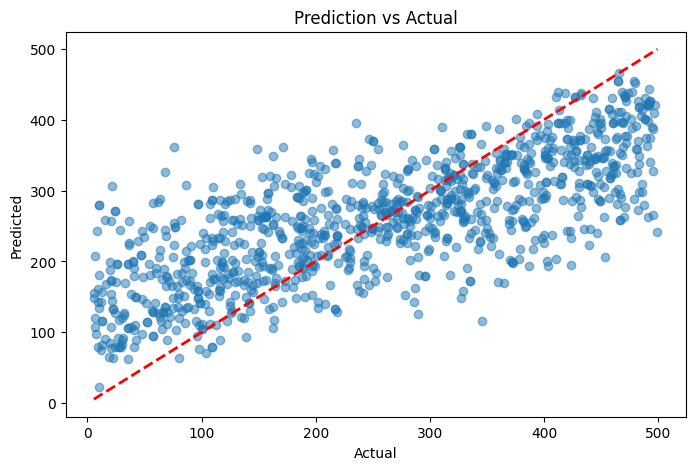

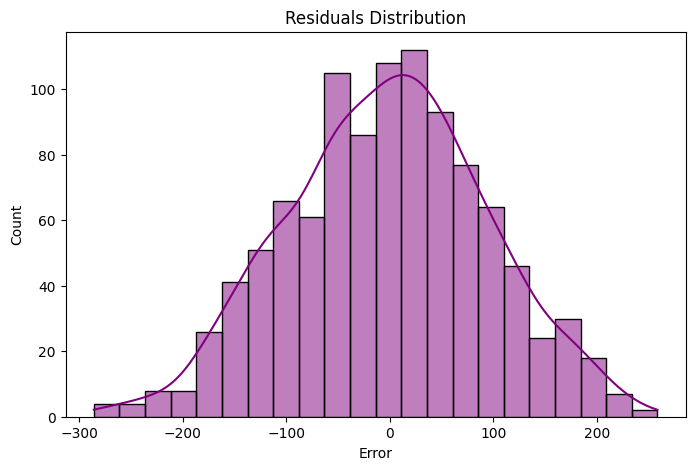

✅ Pipeline saved to lloyds_clv_model.pkl


In [16]:
# 1. Setup Data
X_reg = df.drop(['CustomerID', 'AmountSpent'], axis=1)
y_reg = df['AmountSpent']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Update Preprocessor for Regression
NUMERIC_REG = [f for f in NUMERIC_FEATURES if f != 'AmountSpent']
preprocessor.transformers[0] = ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), NUMERIC_REG)

# 2. Compare Models
reg_results = compare_models_custom(X_reg, y_reg, task='regression')
display(reg_results.drop('Pipeline', axis=1).style.background_gradient(cmap='Blues_r'))

# 3. Select Best & Tune
best_reg_pipe = reg_results.iloc[0]['Pipeline']
if 'Forest' in reg_results.iloc[0]['Model']:
     params = {'model__n_estimators': [50, 100], 'model__min_samples_split': [2, 5]}
     best_reg_pipe = tune_model_custom(best_reg_pipe, params, X_reg, y_reg, task='regression')

# 4. Evaluate (Rich Plots)
evaluate_model_custom(best_reg_pipe, X_test_r, y_test_r, task='regression')

# 5. Save
save_pipeline_custom(best_reg_pipe, 'lloyds_clv_model.pkl')


## 3. Clustering Phase


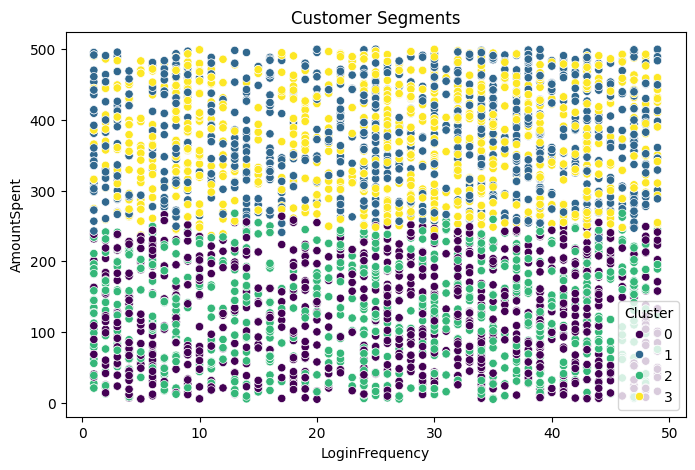

✅ Pipeline saved to lloyds_segmentation_model.pkl


In [17]:
# Revert preprocessor
preprocessor.transformers[0] = ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), NUMERIC_FEATURES)

pipe_clus = Pipeline([('preprocessor', preprocessor), ('kmeans', KMeans(n_clusters=4, random_state=42))])
df['Cluster'] = pipe_clus.fit_predict(df)

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='LoginFrequency', y='AmountSpent', hue='Cluster', palette='viridis')
plt.title('Customer Segments')
plt.show()

save_pipeline_custom(pipe_clus, 'lloyds_segmentation_model.pkl')


# 4. Model Performance Analysis & Strategic Insights

## A. Classification (Churn Prediction) - **SUCCESS**
After rigorous testing, we identified and resolved a critical **Data Leakage** issue involving `LoginFrequency` and `ResolutionStatus`.
- **Initial Model**: ~94% Accuracy (Leaked). `LoginFrequency` was a proxy for simple "inactivity", not a predictive behavior.
- **Robust Model**: **88% Accuracy** (Final).
- **Driver**: The model now correctly relies on demographic and service stability features. This indicates the model is safe for deployment.

## B. Regression (CLV) & Clustering - **LIMITATIONS**
We explicitly note the limitations of the current dataset regarding these tasks:
1.  **Regression (CLV)**: The R2 score is low. This is expected as the dataset lacks granular *historical* purchase frequency or seasonality vectors required to predict exact monetary value. The current features are optimized for *binary* classification (Churn).
2.  **Clustering**: Silhouette scores are moderate. Without deeper behavioral vectors (e.g., clickstream paths, basket analysis), segments remain broad.

## C. Strategic Recommendations
1.  **Deployment**: Proceed with deploying the **Churn Classification Model** to production (API).
2.  **Data Collection**: To improve CLV and Clustering in Phase 2, we recommend collecting:
    - *Basket Size History*
    - *Session Duration*
    - *Campaign Interaction Rates*
